# Visualize the number of historical monuments for each town of the French region Occitanie

In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx

#### *Geodata of all French towns can be found on the French open data portal here: https://www.data.gouv.fr/fr/datasets/decoupage-administratif-communal-francais-issu-d-openstreetmap/*

#### *Data relative to historical monuments can be found on the French open data portal here: https://www.data.gouv.fr/fr/datasets/immeubles-proteges-au-titre-des-monuments-historiques-2/*

#### Load towns/communes with geopandas

In [3]:
osm_fp = "communes-20210101-shp/communes-20210101.shp"
mh_fp = "liste-des-immeubles-proteges-au-titre-des-monuments-historiques.geojson"

In [4]:
com_gdf = gpd.read_file(osm_fp)

In [5]:
com_gdf.head()

,insee,nom,wikipedia,surf_ha,geometry
0,30225,Sabran,fr:Sabran (Gard),3563.0,"POLYGON ((4.49703 44.14344, 4.49727 44.14398, ..."
1,26334,Salettes,fr:Salettes (Drôme),706.0,"POLYGON ((4.94213 44.57481, 4.94283 44.57501, ..."
2,04200,Salignac,fr:Salignac (Alpes-de-Haute-Provence),1435.0,"POLYGON ((5.95337 44.15613, 5.95341 44.15649, ..."
3,04179,Saint-Geniez,fr:Saint-Geniez,3900.0,"POLYGON ((5.98593 44.23280, 5.98654 44.23292, ..."
4,05162,La Saulce,fr:La Saulce,771.0,"POLYGON ((5.98920 44.41892, 5.98921 44.41894, ..."


#### Filter French "communes" from Occitanie region

In [6]:
deps = {"09", "11", "12", "30", "31", "32", "34", "46", "48", "65", "66", "81", "82"}
print(len(deps))

13


In [7]:
print(f"Number of towns in France: {com_gdf.shape[0]}")
occ_com_gdf = com_gdf.query("insee.str.slice(0,2).isin(@deps)")
print(f"Number of towns in Occitanie: {occ_com_gdf.shape[0]}")

Number of towns in France: 34969
Number of towns in Occitanie: 4454


#### Projection in web mercator

In [8]:
occ_com_gdf = occ_com_gdf.to_crs(3857)  # EPSG:4326 to EPSG:3857

#### <br> Load historical monuments with geopandas

In [9]:
mh_gdf = gpd.read_file(mh_fp)

In [10]:
print(mh_gdf.shape[0])
mh_gdf.sample(1)

45684


,commune,stat,insee,dmaj,reg,hist,contact,ploc,code_departement,dpro,...,ref,ppro,wcom,dpt_lettre,adrs,wadrs,autr,affe,desc,geometry
2407,Moulins-Engilbert,propriété privée,58182,2019-11-05,Bourgogne-Franche-Comté,None,mediatheque.patrimoine@culture.gouv.fr,Anciennement région de : Bourgogne,58,1978/12/13 : inscrit MH,...,PA00112924,Façades et toitures des parties subsistantes (...,Moulins-Engilbert,Nièvre,None,None,None,None,None,POINT (3.82369 46.97577)


In [11]:
print(f"Number of historical monuments in France: {mh_gdf.shape[0]}")
occ_mh_gdf = mh_gdf[mh_gdf["code_departement"].isin(deps)]
print(f"Number of historical monuments in Occitanie: {occ_mh_gdf.shape[0]}")

Number of historical monuments in France: 45684
Number of historical monuments in Occitanie: 4942


#### Add the number of historical monuments to communes dataframe

In [12]:
d = dict(occ_mh_gdf["commune"].value_counts())
occ_mh_gdf.query("commune == 'Saint-Martory'").shape[0] == d["Saint-Martory"]

True

In [13]:
occ_com_gdf["nb_mh"] = occ_com_gdf["nom"].apply(lambda x: d.get(x, 0))

#### Check if any row without geometry

In [14]:
occ_com_gdf[occ_com_gdf.isnull().any(axis=1)].shape[0]

0

#### <br> Plot the map (choropleth)

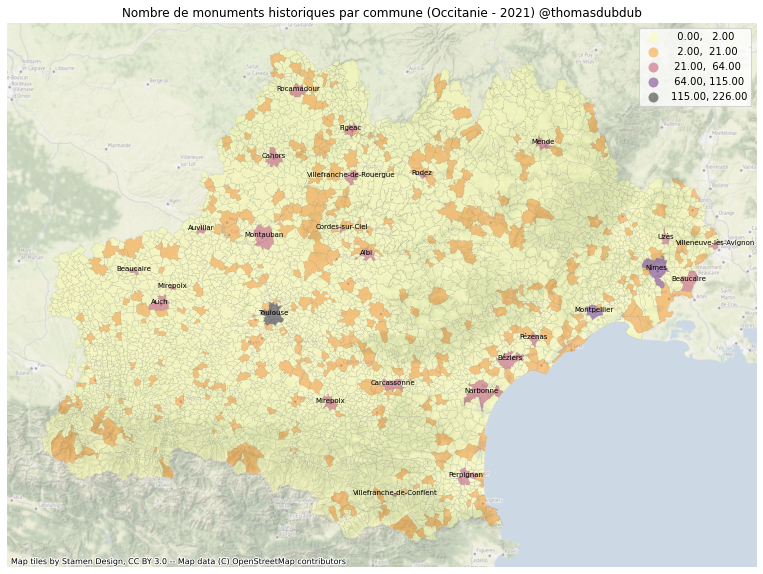

In [15]:
f, ax = plt.subplots(figsize=(20, 10))
occ_com_gdf.plot(
    ax=ax,
    cmap=plt.cm.get_cmap("inferno_r"),  #  "OrRd",
    column="nb_mh",
    scheme="NaturalBreaks",
    legend=True,
    alpha=0.45,
    edgecolor="gray",
    linewidth=0.2,
)
occ_com_gdf.sort_values(by="nb_mh", ascending=False).head(26).apply(
    lambda x: ax.annotate(
        text=x["nom"],
        xy=x.geometry.centroid.coords[0],
        ha="center",
        fontsize=7,
        color="black",
    ),
    axis=1,
)
ax.set_axis_off()
cx.add_basemap(ax, zoom=9, alpha=0.5)
plt.title(
    "Nombre de monuments historiques par commune (Occitanie - 2021) @thomasdubdub"
)
plt.savefig("occitanie-mh.png", dpi=150, bbox_inches="tight")